# Implementing a Language Model 

In [1]:
import torch
from torch import tensor
import torch.nn.functional as F
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from torch.optim import SGD

## Get the Data

In [2]:
import csv
data = open(csv.__file__).read()
data[:100]

'\n"""\ncsv.py - read/write/investigate CSV files\n"""\n\nimport re\nfrom _csv import Error, __version__, w'

In [3]:
data_tensor = torch.tensor(
    [ord(c) for c in data])
data_tensor.shape

torch.Size([16144])

In [4]:
vocab_size = data_tensor.max() + 1

## The Feedforward/MLP Layer

In [5]:
# temporarily embed input vector in a bigger space and chop off all negative components
def MLP(emb_dim, hid_dim): # or called feed-forward network dimension 
    # internal logic -> same dimensionality 
    return nn.Sequential(
        nn.Linear(emb_dim, hid_dim),
        nn.ReLU(),
        nn.Linear(hid_dim, emb_dim)
    ) # make us a sequential layer

## A Single Head Attention

In [21]:
class SingleHeadAttention(nn.Module):
    def __init__(self, emb_dim, head_dim):
        super().__init__()
        self.get_query = nn.Linear(emb_dim, head_dim)
        self.get_key = nn.Linear(emb_dim, head_dim)
        self.get_value = nn.Linear(emb_dim, head_dim)
        
    def forward(self, x): 
        seq_len, emb_dim = x.shape
        
        # get the query vector
        q = self.get_query(x)
        assert q.shape == (seq_len, head_dim)
        
        # get the key vector
        k = self.get_key(x)
        assert k.shape == (seq_len, head_dim)
        
        # get the value vector
        v = self.get_value(x)
        assert v.shape == (seq_len, head_dim)
        
        # invert the key vector
        k_trans = torch.t(k)
        assert k_trans.shape == (head_dim, seq_len)
        # compute the similarity between the query and key to get the attention weights
        similarity = q @ k_trans
        assert similarity.shape == (seq_len, seq_len)
        
        # scale the weights and apply softmax
        scaled_similarity = similarity / (head_dim ** .5)
        attention_weights = scaled_similarity.softmax(dim=1)
        assert attention_weights.shape == (seq_len, seq_len)
        
        # return a value matrix that takes into account the attentions
        return attention_weights @ v

## Multi-head Attention

In [22]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_dim, head_dim, num_heads):
        super().__init__()
        # create multiple attention layers (depending on num_heads)
        self.heads = nn.ModuleList([
            SingleHeadAttention(emb_dim, head_dim) for i in range(num_heads)
        ])
        
        # convert to a format that can be taken in by the MLP
        self.to_output = nn.Linear(num_heads*head_dim, emb_dim, bias=False)

    def forward(self, x):
        # get the outputs from the different attention heads
        head_outputs = [head(x) for head in self.heads]
        # aggregate the outputs from each attention head
        heads_combined = torch.cat(head_outputs, dim=-1)
        # print(f"heads_combined = {heads_combined.shape}") 50 x 30
        # change to a format that can be taken in by the next layer
        out = self.to_output(heads_combined)
        return out

The `Transformer` layer consists of the multi-head attention layer and the MLP layer

In [23]:
class SingleTransformerLayer(nn.Module):
    def __init__(self, embed_dim, head_dim, num_heads, feedforward_dim):
        super().__init__()
        # define multi-head self attention layer
        self.multihead_self_attn = MultiHeadAttention(embed_dim, head_dim, num_heads)
        # define feedforward layer
        self.feedforward = MLP(emb_dim, feedforward_dim)
        
        # For viewing the number of in & out states after going through each layer
        self.norm_after_atten = nn.LayerNorm(emb_dim)
        self.norm_after_feedforward = nn.LayerNorm(emb_dim)
        
    def forward(self, x):
        # 1) go through the attention layer
        x = self.multihead_self_attn(x)
        x = self.norm_after_atten(x)
        # 2) go through the MLP layer
        x = self.feedforward(x)
        x = self.norm_after_feedforward(x)
        return x

In [24]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, max_len, embed_dim, head_dim, fdfw_dim, num_heads):
        super().__init__()
        self.word_to_embedding = nn.Embedding(vocab_size, embed_dim)
        # self.pos_to_embedding = nn.Embedding(max_len, embed_dim)
        self.model = SingleTransformerLayer(embed_dim, head_dim, num_heads, fdfw_dim)
        self.lm_head = nn.Linear(emb_dim, vocab_size, bias=True)
        
    def forward(self, x):
        # get the word embeddings
        x = self.word_to_embedding(x)
        # get the position embeddings
        # position_ids = torch.arrange(input_ids.shape[-1])
        # pos_embeddings = self.pos_to_embedding(position_ids)
        
        #x = word_embeddings + pos_embeddings
        x = self.model(x)
        
        return self.lm_head(x)

## Define some constants

In [25]:
num_heads = 3
emb_dim = 5
head_dim = emb_dim // num_heads
d_feed_forward = emb_dim * 4

In [26]:
model = Transformer(vocab_size=vocab_size, max_len=50, embed_dim=emb_dim, head_dim=head_dim, fdfw_dim=d_feed_forward, num_heads=num_heads)

## View the model

<AxesSubplot:>

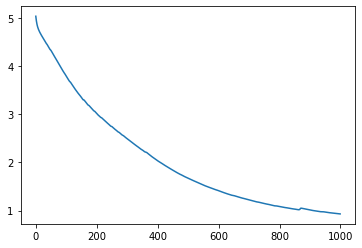

In [27]:
# optimizer
optimizer = SGD(model.parameters(), lr=.05)

seq_length = 50

losses = []
# one epoch = one complete pass
# not doing epochs not.. take random samples
for batch_idx in range(1000): 
    # get one batch or data
    start_at = 0 #random.randrange(size - sequence_length - 1)
    input_ids = data_tensor[start_at:start_at+seq_length]
    #print(input_ids)
    targets = data_tensor[start_at + 1:start_at + 1 + seq_length]
    #print(targets)
    
    # give the data to the model, ask for predictions
    logits = model(input_ids)
    
    # compute loss
    loss = F.cross_entropy(logits, targets)
    losses.append(loss.item())
    
    # backpropagate
    loss.backward()
    
    # step the optimizer
    optimizer.step()
    optimizer.zero_grad()

pd.Series(losses).ewm(alpha = .01).mean().plot()